# Fake news detection

I tried to build a function that uses a ML model to give a confidence score between 1 and 0 (is this article reliable or not) to any article found on the internet.


## 1. Let's set up our environment

In [130]:
# Ignore warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Computations
import itertools

# Modelling Algorithms
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier

# Modelling Helpers
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

# Visualization
import matplotlib.pyplot as plt

# Scrapping 
from newspaper import Article

In [3]:
# Let's import and prep the datasets

# Import the datasets 
train=pd.read_csv('../train.csv')
test=pd.read_csv('../test.csv')

# Handle missing values
test=test.fillna(' ')
train=train.fillna(' ')

# Create a column with all the data available
test['total']=test['title']+' '+test['author']+' '+test['text']
train['total']=train['title']+' '+train['author']+' '+train['text']

# Have a glance at our training set
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 6 columns):
id        20800 non-null int64
title     20800 non-null object
author    20800 non-null object
text      20800 non-null object
label     20800 non-null int64
total     20800 non-null object
dtypes: int64(2), object(4)
memory usage: 975.1+ KB


,id,title,author,text,label,total
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


I decided to train my model on a concatenation of the title, the author and the main text, because I thought adding more words to the input might increase the reliablity of my model.

In [6]:
# Dividing our training set into a sub-training and a sub-testing set to assess our results
X_train, X_test, y_train, y_test = train_test_split(train['total'], train.label, test_size=0.20, random_state=0)

I decided to divide our training sets in two in order to be able to assess the accuracy of our results. Indeed, the "expected" result is not given in the Kaggle test set.

The metrics I will use in order to assess my models are the following:
- accuracy : number of times I got the right figure (when classifying)
- number of false negative (I classified as a real news when it was actually a fake news).

For this second metrics, I assume I want to minimize this rather than the number of false positive, because I really do not want to push fake news. This is of course a biased point of view, and we could adopt the contrary opinion.

## 2. Let's build vectorizer classifiers

Since we are trying to classify text strings, we first want to vectorize our data. I will use two different vectorizers and compare them
- The Count Vectorizer counts the number of appearances of a word in the text string
- The Tf-IDF Vectorizer is the frequency of appareance of a word * the inversed frequency of appearance in the whole corpus

I will start with ngram_range = (1,2), then try to refine this parameter.

### 1. Count Vectorizer

In [25]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english') 
# Fit and transform the training data.
count_train = count_vectorizer.fit_transform(X_train)
# Transform the test set 
count_test = count_vectorizer.transform(X_test)

### 2. Tf-IDF Vectorizer

In [74]:
#Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
#Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
#Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

## 3. Let's try different models

### 1. Multinomial Naive Bayes

I will start by trying a Multinomial Naive Bayes, a very common and simple classifier.

#### 1. Multinomial NB with Count Vectorizer

In [38]:
# Let's run the model and get its accuracy score

nb_classifier = MultinomialNB(alpha = 0.1)
nb_classifier.fit(count_train, y_train)
pred_nb_count = nb_classifier.predict(count_test)
acc_nb_count = metrics.accuracy_score(y_test, pred_nb_count)
print(acc_nb_count)

0.942548076923077


In [65]:
# Let's tune our parameter alpha

for alpha in np.arange(0,1,.05):
    nb_classifier_tune = MultinomialNB(alpha=alpha)
    nb_classifier_tune.fit(count_train, y_train)
    pred_tune = nb_classifier_tune.predict(count_test)
    score = metrics.accuracy_score(y_test, pred_tune)
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

Alpha: 0.00 Score: 0.91106
Alpha: 0.05 Score: 0.94183
Alpha: 0.10 Score: 0.94255
Alpha: 0.15 Score: 0.94279
Alpha: 0.20 Score: 0.94231
Alpha: 0.25 Score: 0.94111
Alpha: 0.30 Score: 0.93990
Alpha: 0.35 Score: 0.93822
Alpha: 0.40 Score: 0.93750
Alpha: 0.45 Score: 0.93630
Alpha: 0.50 Score: 0.93510
Alpha: 0.55 Score: 0.93486
Alpha: 0.60 Score: 0.93341
Alpha: 0.65 Score: 0.93149
Alpha: 0.70 Score: 0.93029
Alpha: 0.75 Score: 0.92909
Alpha: 0.80 Score: 0.92788
Alpha: 0.85 Score: 0.92644
Alpha: 0.90 Score: 0.92428
Alpha: 0.95 Score: 0.92308


The best score is obtained for alpha = 0.15, and is equal to 0.94279. This is already quite good! I will now quickly check that using n_gram = (1,2) gives better results than using n_gram = (1,1) :

In [64]:
# Initialize the `count_vectorizer` 
count_vectorizer_singlewords = CountVectorizer(ngram_range=(1, 1), stop_words='english') 
# Fit and transform the training data.
count_train_singlewords = count_vectorizer_singlewords.fit_transform(X_train)
# Transform the test set 
count_test_singlewords = count_vectorizer_singlewords.transform(X_test)

for alpha in np.arange(0,1,.05):
    nb_classifier_tune = MultinomialNB(alpha=alpha)
    nb_classifier_tune.fit(count_train_singlewords, y_train)
    pred_tune = nb_classifier_tune.predict(count_test_singlewords)
    score = metrics.accuracy_score(y_test, pred_tune)
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))


Alpha: 0.00 Score: 0.90865
Alpha: 0.05 Score: 0.91563
Alpha: 0.10 Score: 0.91490
Alpha: 0.15 Score: 0.91322
Alpha: 0.20 Score: 0.91274
Alpha: 0.25 Score: 0.91226
Alpha: 0.30 Score: 0.91082
Alpha: 0.35 Score: 0.91034
Alpha: 0.40 Score: 0.90986
Alpha: 0.45 Score: 0.90865
Alpha: 0.50 Score: 0.90721
Alpha: 0.55 Score: 0.90673
Alpha: 0.60 Score: 0.90697
Alpha: 0.65 Score: 0.90721
Alpha: 0.70 Score: 0.90721
Alpha: 0.75 Score: 0.90649
Alpha: 0.80 Score: 0.90649
Alpha: 0.85 Score: 0.90625
Alpha: 0.90 Score: 0.90625
Alpha: 0.95 Score: 0.90577


For each alpha, the score is lower when we use (1,1) as a parameter for ngram_range instead of (1,2).   
Indeed, it seems logical that considering two-words phrases adds information to our dataset and therefore helps better train our model.  
I will now always use ngram_range = (1,2)   

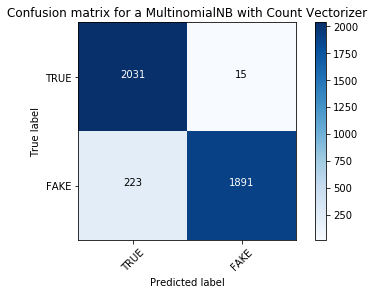

In [31]:
# Let's re-run our fine-tuned model and plot the confusion matrix
nb_classifier = MultinomialNB(alpha = 0.15)
nb_classifier.fit(count_train, y_train)
pred_nb_count = nb_classifier.predict(count_test)
cm = metrics.confusion_matrix(y_test, pred_nb_count, labels=[0,1])

# Creating a function that outputs a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
plot_confusion_matrix(cm, classes=['TRUE','FAKE'], title ='Confusion matrix for a MultinomialNB with Count Vectorizer')

Although our model has a general accuracy of 94,3 %, which is not bad, it does not really score well in view of our second metrics, ie the number of false negative. Indeed, 223 fake news are classified as true news with this model, which is not satisfying.   
I will try to use the Tf-IDF vectorizer on this same model to see if it performs better. 

#### 2. MulitnomialNB with Td-IDF Vectorizer

In [56]:
# Let's run the model and get an accuracy score.

nb_classifier = MultinomialNB(alpha = 0.1)
nb_classifier.fit(tfidf_train, y_train)
pred_nb_tfidf = nb_classifier.predict(tfidf_test)
acc_nb_tfidf = metrics.accuracy_score(y_test, pred_nb_tfidf)
print(acc_nb_tfidf)

0.926923076923077


In [75]:
# Let's refine parameter alpha

for alpha in np.arange(0,0.1,.01):
    nb_classifier_tune = MultinomialNB(alpha=alpha)
    nb_classifier_tune.fit(tfidf_train, y_train)
    pred_tune = nb_classifier_tune.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred_tune)
    print("Alpha: {:.2f}  Score: {:.5f}".format(alpha, score))

Alpha: 0.00  Score: 0.90649
Alpha: 0.01  Score: 0.94375
Alpha: 0.02  Score: 0.94375
Alpha: 0.03  Score: 0.94159
Alpha: 0.04  Score: 0.93966
Alpha: 0.05  Score: 0.93822
Alpha: 0.06  Score: 0.93462
Alpha: 0.07  Score: 0.93317
Alpha: 0.08  Score: 0.93005
Alpha: 0.09  Score: 0.92861


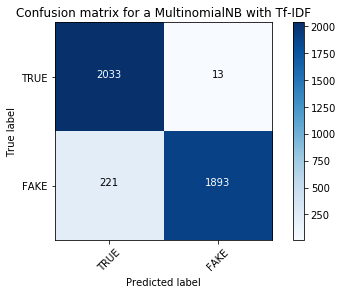

In [77]:
# Let's run the optimized model and check the confusion matrix
nb_classifier = MultinomialNB(alpha = 0.01)
nb_classifier.fit(tfidf_train, y_train)
pred_nb_tfidf = nb_classifier.predict(tfidf_test)
cm2 = metrics.confusion_matrix(y_test, pred_nb_tfidf, labels=[0,1])
plot_confusion_matrix(cm2, classes=['TRUE','FAKE'], title ='Confusion matrix for a MultinomialNB with Tf-IDF')

The confusion matrix confirms that this new model is slightly better (and its accuracy score is 94,4 %).  
However, too many fake news are still labeled as true news. Let's try another model.

### 2. Passive Agressive Classifier

#### 1. With Count Vectorizer

0.9670673076923076


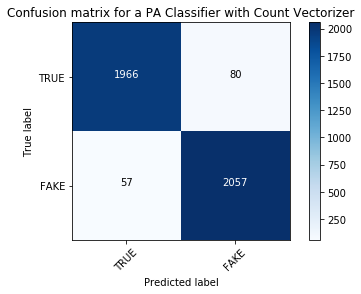

In [98]:
linear_classifier = PassiveAggressiveClassifier(n_iter=10)
linear_classifier.fit(count_train, y_train)
pred_linear_count = linear_classifier.predict(count_test)
acc_linear_count = metrics.accuracy_score(y_test, pred_linear_count)
print(acc_linear_count)
cm6 = metrics.confusion_matrix(y_test, pred_linear_count, labels=[0,1])
plot_confusion_matrix(cm6, classes=['TRUE','FAKE'], title ='Confusion matrix for a PA Classifier with Count Vectorizer')

We get much better results than with the MultinomialNB model, both in terms of accuracy and in terms of false negative. Only 57 fake news were labeled as true news this time.   
Let's try with the Tf-IDF method.

#### 2. With Tf-IDF

0.9795673076923077


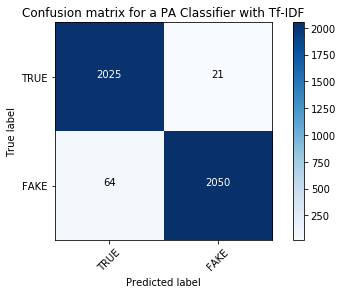

In [97]:
linear_classifier = PassiveAggressiveClassifier(n_iter=10)
linear_classifier.fit(tfidf_train, y_train)
pred_linear_tfidf = linear_classifier.predict(tfidf_test)
acc_linear_tfidf = metrics.accuracy_score(y_test, pred_linear_tfidf)
print(acc_linear_tfidf)
cm5 = metrics.confusion_matrix(y_test, pred_linear_tfidf, labels=[0,1])
plot_confusion_matrix(cm5, classes=['TRUE','FAKE'], title ='Confusion matrix for a PA Classifier with Tf-IDF')

Although we observe more false negative, the overall accuracy is much better, so so far it is our best model.  
Let's try a final model before making a choice.

### 3. Logistic Regression

Let's try to use a logistic regression as a classifier for this dataset.

#### 1. With Tf-IDF

0.9807692307692307


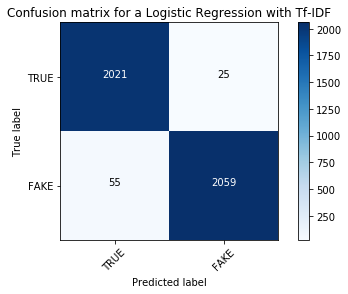

In [96]:
logreg = LogisticRegression(C=1e5)
logreg.fit(tfidf_train, y_train)
pred_logreg_tfidf = logreg.predict(tfidf_test)
pred_logreg_tfidf_proba = logreg.predict_proba(tfidf_test)[:,1]
acc_logreg_tfidf = metrics.accuracy_score(y_test,pred_logreg_tfidf)
print(acc_logreg_tfidf)
cm4 = metrics.confusion_matrix(y_test, pred_logreg_tfidf, labels=[0,1])
plot_confusion_matrix(cm4, classes=['TRUE','FAKE'], title ='Confusion matrix for a Logistic Regression with Tf-IDF')

This model has a very high accuracy score, so we might consider keeping it as our final model.  
But let's first check what we would obtain with Count Vectorizer

#### 2. With Count Vectorizer

0.9769230769230769


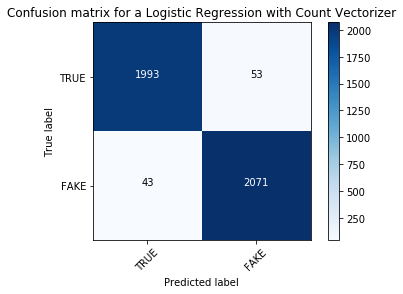

In [95]:
logreg = LogisticRegression(C=1e5)
logreg.fit(count_train, y_train)
pred_logreg_count = logreg.predict(count_test)
acc_logreg_count = metrics.accuracy_score(y_test,pred_logreg_count)
print(acc_logreg_count)
cm3 = metrics.confusion_matrix(y_test, pred_logreg_count, labels=[0,1])
plot_confusion_matrix(cm3, classes=['TRUE','FAKE'], title ='Confusion matrix for a Logistic Regression with Count Vectorizer')

It's even better! This is our favorite model so far. Indeed, even though the accuracy score is a bit lower, we have less fake news labeled as true news. Therefore, I choose this model because it seems to maximize the accuracy while minimizing the false negative rate. 

## 4. Confidence score

I now want to be able to give a confidence score between 0 and 1 to estimate whether an article is a fake news or not.

#### 1. I first create a function that gives the confidence score for any article in the test set

In [107]:
# The input of this function is the string that is in the total column of the test set (concat of title, authors, text)

def confidence_score_from_dataset(text_total_article):
    
    count_test_article = count_vectorizer.transform(text_total_article)
    pred_logreg_count_article = logreg.predict(count_test_article)
    pred_logreg_count_proba_article = logreg.predict_proba(count_test_article)[:,1]
    print(pred_logreg_count_proba_article)

In [108]:
# Let's try my function on articles from the test set
text_total_article_1 = X_test[2:3]
print(text_total_article_1)
confidence_score_from_dataset(text_total_article_1)
print('Article 5500 has a very high probability of being a fake news')

text_total_article_2 = X_test[0:1]
print(text_total_article_2)
confidence_score_from_dataset(text_total_article_2)
print('Article 20386 has a very low probability of being a fake news')

5500    Solar Storm Alert No Author October 27, 2016 S...
Name: total, dtype: object
[0.99999952]
Article 5500 has a very high probability of being a fake news
20386    Bob Dylan’s Nobel Prize: A Podcast Discussion ...
Name: total, dtype: object
[0.00014664]
Article 20386 has a very low probability of being a fake news


#### 2. I now create a function that gives the confidence score for any article of the internet

In [109]:
def give_score(link):
    article = Article(link)
    article.download()
    article.parse()
    authors = article.authors
    text = article.text
    title = article.title
    total = title + ' ' + str(authors) + ' ' + str(text)
    total_array = [total]
    confidence_score_from_dataset(total_array)
    

In [129]:
# Let's now test my function
link_nbc ='https://www.nbcnews.com/politics/elections/democrats-won-house-popular-vote-largest-midterm-margin-watergate-n938996?cid=par-nbc_20181121'
link_bbc = 'https://www.bbc.com/news/world-middle-east-46288510'
link_bbc_Trump  = 'https://www.bbc.com/news/world-us-canada-46294734'
give_score(link_nbc)
give_score(link_bbc)
give_score(link_bbc_Trump)


[0.92686628]
[0.95043256]
[2.48103681e-05]


These final results show that we need to be careful with our predictions.  
Indeed, although the first two articles passed the test, and righly so, the third article failed even though it was a real article. It is therefore a " false positive".  
In this project, I chose to favor minimizing false negative instead of minimizing false positives, which might be one of the reason we observe this.  
Another reason could be that our model is learning that some words are associated with a high probability of being a fake news ; Trump might be one of these words...